### Discord Exfiltration - Anomaly Detection

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
# Unsupervised learning evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import lognorm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

#### Dataset import and cleaning

In [5]:
# Read the CSV file (remove the index column)
discord_normal_observation_dataset = pd.read_csv('features/alex_sample2_features_m3_w[300]_s30.csv', delimiter=',')

# Display the first few rows of the dataframe
print("Big Normal Shape: ",discord_normal_observation_dataset.shape)
discord_normal_observation_dataset.head()

Big Normal Shape:  (1207, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,8.258,66.450,1.419,0.631,1.0,3.0,123.963,676.990,2305.174,27513.067,...,470.280,2024.587,2686.65,7452.08,979.85,3755.04,2615.150,28680.764,3.880,29.391
1,10.680,78.138,1.375,0.651,1.0,2.7,123.314,677.065,2040.466,27457.893,...,311.480,1830.363,200.50,4722.90,654.70,2588.92,2261.493,28557.129,3.237,29.007
2,10.920,82.714,1.125,0.193,1.0,1.0,121.537,673.114,1046.289,868.867,...,116.197,79.370,120.55,1385.36,416.45,701.62,307.027,2503.127,1.003,4.394
3,11.500,77.667,1.043,0.042,1.0,1.0,40.085,103.280,643.053,390.804,...,68.237,34.377,92.45,132.58,266.10,552.72,147.790,1067.640,0.693,2.708
4,12.043,122.737,1.045,0.043,1.0,1.0,39.886,97.910,643.053,390.804,...,68.237,34.377,91.00,132.58,248.15,552.72,145.800,1067.135,0.683,2.685


In [6]:
discord_small_normal_observation_dataset = pd.read_csv('features/alex_sample_features_m3_w[300]_s30.csv', delimiter=',')

print("Small Normal Shape: ",discord_small_normal_observation_dataset.shape)
discord_small_normal_observation_dataset.head()

Small Normal Shape:  (510, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,9.214,102.740,1.500,0.821,1.0,2.3,57.244,140.173,1935.232,95954.571,...,306.107,6954.563,921.60,3239.04,859.40,9706.62,7332.110,97236.783,7.913,89.738
1,8.467,95.582,1.586,1.001,1.0,3.0,58.611,152.980,2234.770,95952.288,...,436.623,6992.230,2179.20,7357.46,1271.75,9706.62,7508.877,97234.209,8.337,89.752
2,7.844,93.319,1.581,0.953,1.0,3.0,59.766,148.388,2248.605,95951.572,...,464.500,7002.963,2259.80,7357.46,1590.40,9706.62,7547.907,97232.045,8.417,89.748
3,6.861,79.120,1.514,0.878,1.0,2.6,72.385,152.524,2255.933,95951.198,...,482.800,7008.413,2696.75,7357.46,1590.40,9706.62,7580.517,97230.125,8.513,89.742
4,6.944,77.164,1.429,0.816,1.0,2.0,57.021,155.762,2240.729,95952.112,...,451.647,6994.777,2185.70,7357.46,1190.05,9706.62,7534.003,97232.741,8.400,89.745


In [7]:
discord_malicious_observation_dataset = pd.read_csv('features/ana_sample2_features_m3_w[300]_s30.csv', delimiter=',')

print("Malicious Shape: ",discord_malicious_observation_dataset.shape)
discord_malicious_observation_dataset.head()

Malicious Shape:  (133, 22)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,60_percentile_activity_duration,90_percentile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,udp_download_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,3.709,21.879,1.745,2.044,1.0,3.6,296438.236,1870.213,1279.114,9151.271,...,424.767,910.933,2965.3,10849.80,2211.60,8090.56,31406.230,298088.890,27.600,238.067
1,3.643,15.551,1.714,2.026,1.0,3.5,296437.177,1724.473,1279.114,9151.271,...,424.767,910.933,2870.1,9069.70,2040.35,5076.80,31113.830,298091.784,27.213,238.061
2,3.855,17.179,1.600,1.258,1.0,3.0,296437.383,1724.746,1022.896,9149.213,...,320.490,859.863,2800.6,7447.30,1841.70,4359.44,30948.477,298106.620,26.823,238.088
3,4.231,19.139,1.569,1.265,1.0,3.0,296437.624,1725.228,1013.778,9149.841,...,290.047,844.700,2800.6,7447.30,1681.15,4359.44,30893.180,298112.114,26.647,238.105
4,4.714,38.898,1.438,1.079,1.0,2.0,223657.374,1188.148,1018.050,9150.617,...,274.950,840.477,2176.3,4651.84,1565.30,2403.86,14535.367,224904.777,13.250,178.111


In [8]:
print("Normal Big Capture Before Cleaning: ",discord_normal_observation_dataset.shape)
print("Normal Small Capture Before Cleaning: ",discord_small_normal_observation_dataset.shape)
print("Malicious Capture Before Cleaning: ",discord_malicious_observation_dataset.shape)

# Remove all the rows with 'mean_activity_duration' == 0
discord_normal_observation_dataset = discord_normal_observation_dataset[discord_normal_observation_dataset['mean_activity_duration'] != 0]
discord_small_normal_observation_dataset = discord_small_normal_observation_dataset[discord_small_normal_observation_dataset['mean_activity_duration'] != 0]
discord_malicious_observation_dataset = discord_malicious_observation_dataset[discord_malicious_observation_dataset['mean_activity_duration'] != 0]

print("\n\nNormal Big Capture After Cleaning", discord_normal_observation_dataset.shape)
print("Normal Small Capture After Cleaning", discord_small_normal_observation_dataset.shape)
print("Malicious Capture After Cleaning", discord_malicious_observation_dataset.shape)

Normal Big Capture Before Cleaning:  (1207, 22)
Normal Small Capture Before Cleaning:  (510, 22)
Malicious Capture Before Cleaning:  (133, 22)


Normal Big Capture After Cleaning (1207, 22)
Normal Small Capture After Cleaning (510, 22)
Malicious Capture After Cleaning (133, 22)


#### Dataset Analysis

##### Distribution of the Mean Silence Duration

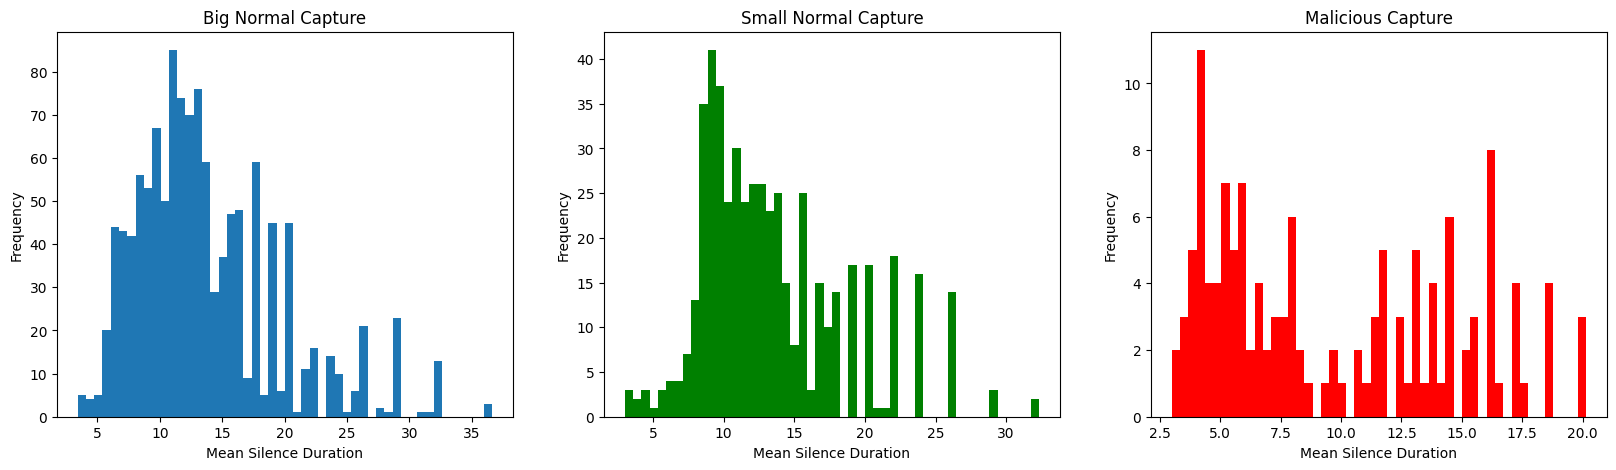

In [76]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(discord_normal_observation_dataset['mean_silence_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Silence Duration')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(discord_small_normal_observation_dataset['mean_silence_duration'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Mean Silence Duration')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(discord_malicious_observation_dataset['mean_silence_duration'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Mean Silence Duration')
plt.ylabel('Frequency')
plt.show()

##### Distribution of the Mean Activity Duration

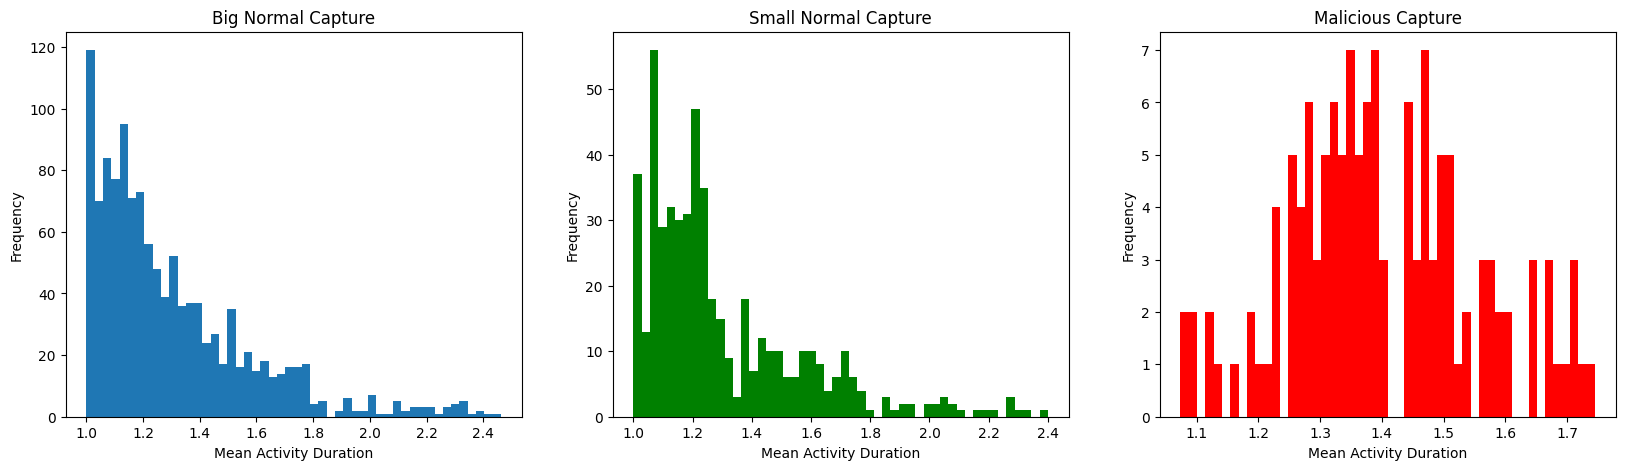

In [77]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(discord_normal_observation_dataset['mean_activity_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Activity Duration')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(discord_small_normal_observation_dataset['mean_activity_duration'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Mean Activity Duration')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(discord_malicious_observation_dataset['mean_activity_duration'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Mean Activity Duration')
plt.ylabel('Frequency')
plt.show()

##### Upload/Download Ratio Scatter

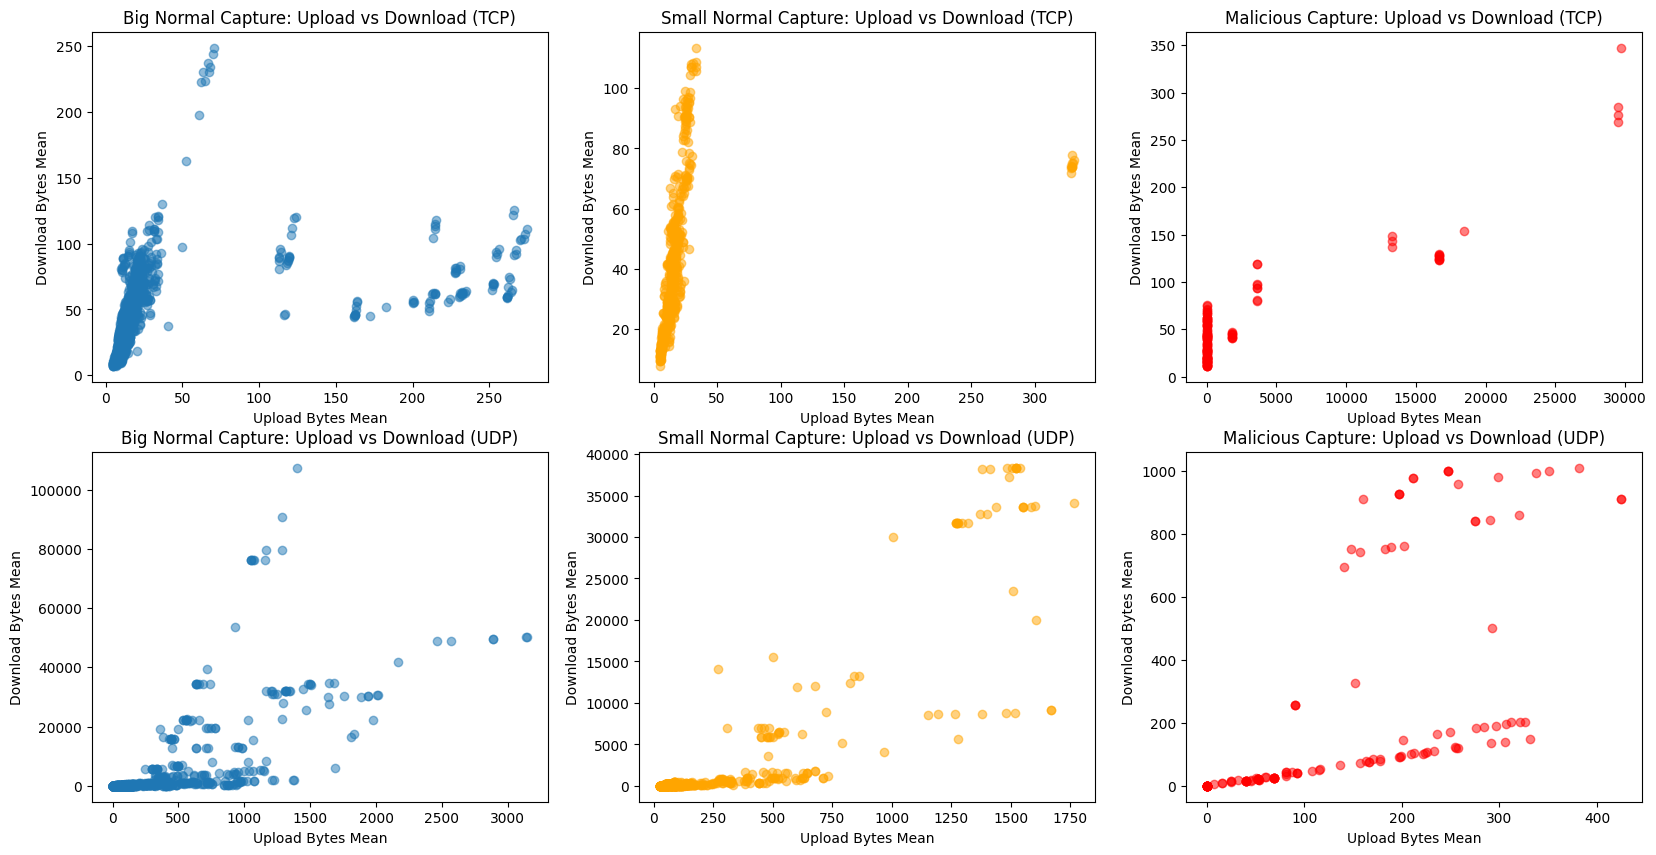

In [11]:
plt.figure(figsize=(20, 10))

# Scatter Plot for Upload vs Download
plt.subplot(2, 3, 1)
plt.scatter(discord_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5)
plt.title('Big Normal Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 2)
plt.scatter(discord_small_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_small_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5, color='orange')
plt.title('Small Normal Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 3)
plt.scatter(discord_malicious_observation_dataset['tcp_upload_bytes_mean'],
            discord_malicious_observation_dataset['tcp_download_bytes_mean'], alpha=0.5, color='red')
plt.title('Malicious Capture: Upload vs Download (TCP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

# The same for UDP

plt.subplot(2, 3, 4)
plt.scatter(discord_normal_observation_dataset['udp_upload_bytes_mean'],
            discord_normal_observation_dataset['udp_download_bytes_mean'], alpha=0.5)
plt.title('Big Normal Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 5)
plt.scatter(discord_small_normal_observation_dataset['udp_upload_bytes_mean'],
            discord_small_normal_observation_dataset['udp_download_bytes_mean'], alpha=0.5, color='orange')
plt.title('Small Normal Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 3, 6)
plt.scatter(discord_malicious_observation_dataset['udp_upload_bytes_mean'],
            discord_malicious_observation_dataset['udp_download_bytes_mean'], alpha=0.5, color='red')
plt.title('Malicious Capture: Upload vs Download (UDP)')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.show()

##### Upload/Download Histogram

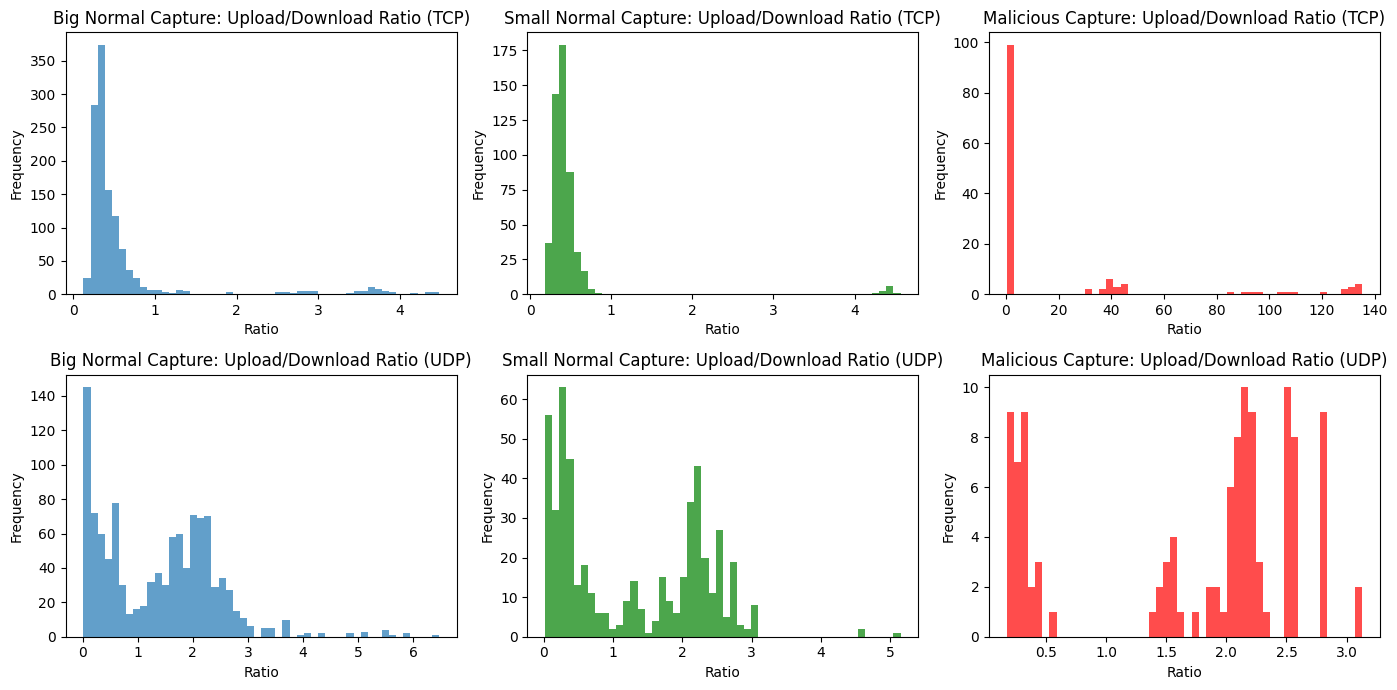

In [12]:
# Calculate upload/download ratios temporarily
normal_ratios_tcp = (discord_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_normal_observation_dataset['tcp_download_bytes_mean'])
small_normal_ratios_tcp = (discord_small_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_small_normal_observation_dataset['tcp_download_bytes_mean'])
malicious_ratios_tcp = (discord_malicious_observation_dataset['tcp_upload_bytes_mean'] / discord_malicious_observation_dataset['tcp_download_bytes_mean'])

normal_ratios_udp = (discord_normal_observation_dataset['udp_upload_bytes_mean'] / discord_normal_observation_dataset['udp_download_bytes_mean'])
small_normal_ratios_udp = (discord_small_normal_observation_dataset['udp_upload_bytes_mean'] / discord_small_normal_observation_dataset['udp_download_bytes_mean'])
malicious_ratios_udp = (discord_malicious_observation_dataset['udp_upload_bytes_mean'] / discord_malicious_observation_dataset['udp_download_bytes_mean'])

plt.figure(figsize=(14, 7))

# Ratio Histograms
plt.subplot(2, 3, 1)
plt.hist(normal_ratios_tcp, bins=50, alpha=0.7)
plt.title('Big Normal Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(small_normal_ratios_tcp, bins=50, alpha=0.7, color='green')
plt.title('Small Normal Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(malicious_ratios_tcp, bins=50, alpha=0.7, color='red')
plt.title('Malicious Capture: Upload/Download Ratio (TCP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(normal_ratios_udp, bins=50, alpha=0.7)
plt.title('Big Normal Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(small_normal_ratios_udp, bins=50, alpha=0.7, color='green')
plt.title('Small Normal Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(malicious_ratios_udp, bins=50, alpha=0.7, color='red')
plt.title('Malicious Capture: Upload/Download Ratio (UDP)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Standard Deviation Bell Graph

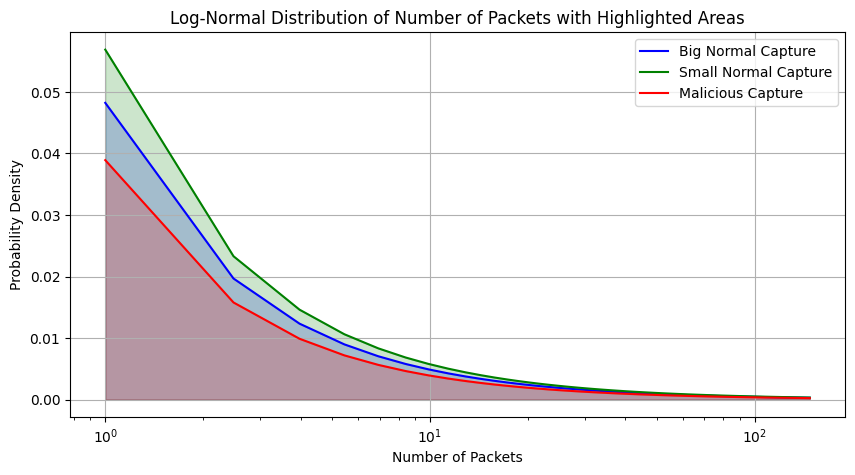

In [53]:
normal_std_dev = discord_normal_observation_dataset['packets_std_dev'].mean()
small_normal_std_dev = discord_small_normal_observation_dataset['packets_std_dev'].mean()
malicious_std_dev = discord_malicious_observation_dataset['packets_std_dev'].mean()

normal_mean = discord_normal_observation_dataset['packets_mean'].mean()
small_normal_mean = discord_small_normal_observation_dataset['packets_mean'].mean()
malicious_mean = discord_malicious_observation_dataset['packets_mean'].mean()

# Generate x-axis dynamically based on byte range
x_min = 1  # Start from 1 since log-normal requires positive values
x_max = max(normal_mean + 4 * normal_std_dev,
            small_normal_mean + 4 * small_normal_std_dev,
            malicious_mean + 4 * malicious_std_dev)
x = np.linspace(x_min, x_max, 100)

# Log-normal PDFs
shape_normal = normal_std_dev / normal_mean
scale_normal = normal_mean
normal_pdf = lognorm.pdf(x, s=shape_normal, scale=scale_normal)

shape_small = small_normal_std_dev / small_normal_mean
scale_small = small_normal_mean
small_normal_pdf = lognorm.pdf(x, s=shape_small, scale=scale_small)

shape_malicious = malicious_std_dev / malicious_mean
scale_malicious = malicious_mean
malicious_pdf = lognorm.pdf(x, s=shape_malicious, scale=scale_malicious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, normal_pdf, label='Big Normal Capture', color='blue')
plt.plot(x, small_normal_pdf, label='Small Normal Capture', color='green')
plt.plot(x, malicious_pdf, label='Malicious Capture', color='red')

# Highlight Areas Under Curve
plt.fill_between(x, normal_pdf, alpha=0.2, color='blue')
plt.fill_between(x, small_normal_pdf, alpha=0.2, color='green')
plt.fill_between(x, malicious_pdf, alpha=0.2, color='red')

# Add titles and labels
plt.title('Log-Normal Distribution of Number of Packets with Highlighted Areas')
plt.xlabel('Number of Packets')
plt.ylabel('Probability Density')
plt.xscale('log')  # Apply log scale on X-axis
plt.legend()
plt.grid(True)

plt.show()

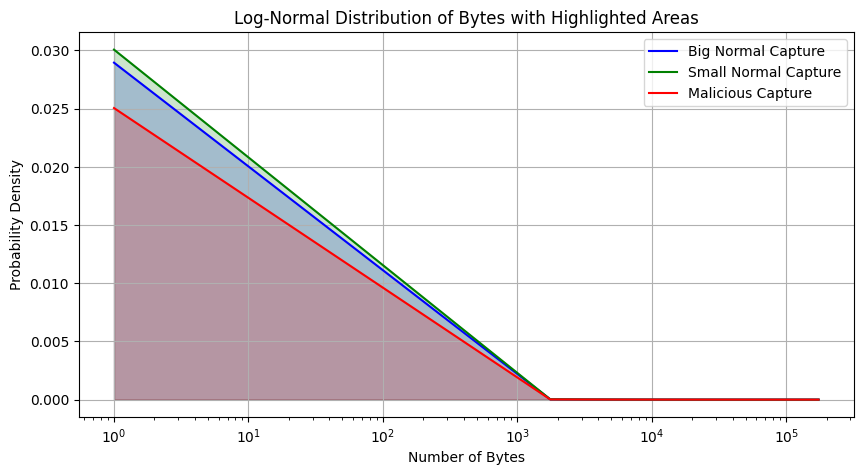

In [ ]:
normal_std_dev = discord_normal_observation_dataset['bytes_std_dev'].mean()
small_normal_std_dev = discord_small_normal_observation_dataset['bytes_std_dev'].mean()
malicious_std_dev = discord_malicious_observation_dataset['bytes_std_dev'].mean()

normal_mean = discord_normal_observation_dataset['bytes_mean'].mean()
small_normal_mean = discord_small_normal_observation_dataset['bytes_mean'].mean()
malicious_mean = discord_malicious_observation_dataset['bytes_mean'].mean()

# Generate x-axis dynamically based on byte range
x_min = 1  # Start from 1 since log-normal requires positive values
x_max = max(normal_mean + 4 * normal_std_dev,
            small_normal_mean + 4 * small_normal_std_dev,
            malicious_mean + 4 * malicious_std_dev)
x = np.linspace(x_min, x_max, 100)

# Log-normal PDFs
shape_normal = normal_std_dev / normal_mean
scale_normal = normal_mean
normal_pdf = lognorm.pdf(x, s=shape_normal, scale=scale_normal)

shape_small = small_normal_std_dev / small_normal_mean
scale_small = small_normal_mean
small_normal_pdf = lognorm.pdf(x, s=shape_small, scale=scale_small)

shape_malicious = malicious_std_dev / malicious_mean
scale_malicious = malicious_mean
malicious_pdf = lognorm.pdf(x, s=shape_malicious, scale=scale_malicious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, normal_pdf, label='Big Normal Capture', color='blue')
plt.plot(x, small_normal_pdf, label='Small Normal Capture', color='green')
plt.plot(x, malicious_pdf, label='Malicious Capture', color='red')

# Highlight Areas Under Curve
plt.fill_between(x, normal_pdf, alpha=0.2, color='blue')
plt.fill_between(x, small_normal_pdf, alpha=0.2, color='green')
plt.fill_between(x, malicious_pdf, alpha=0.2, color='red')

# Add titles and labels
plt.title('Log-Normal Distribution of Bytes with Highlighted Areas')
plt.xlabel('Number of Bytes')
plt.ylabel('Probability Density')
plt.xscale('log')  # Apply log scale on X-axis
plt.legend()
plt.grid(True)

plt.show()

##### Standard Deviation Distribution

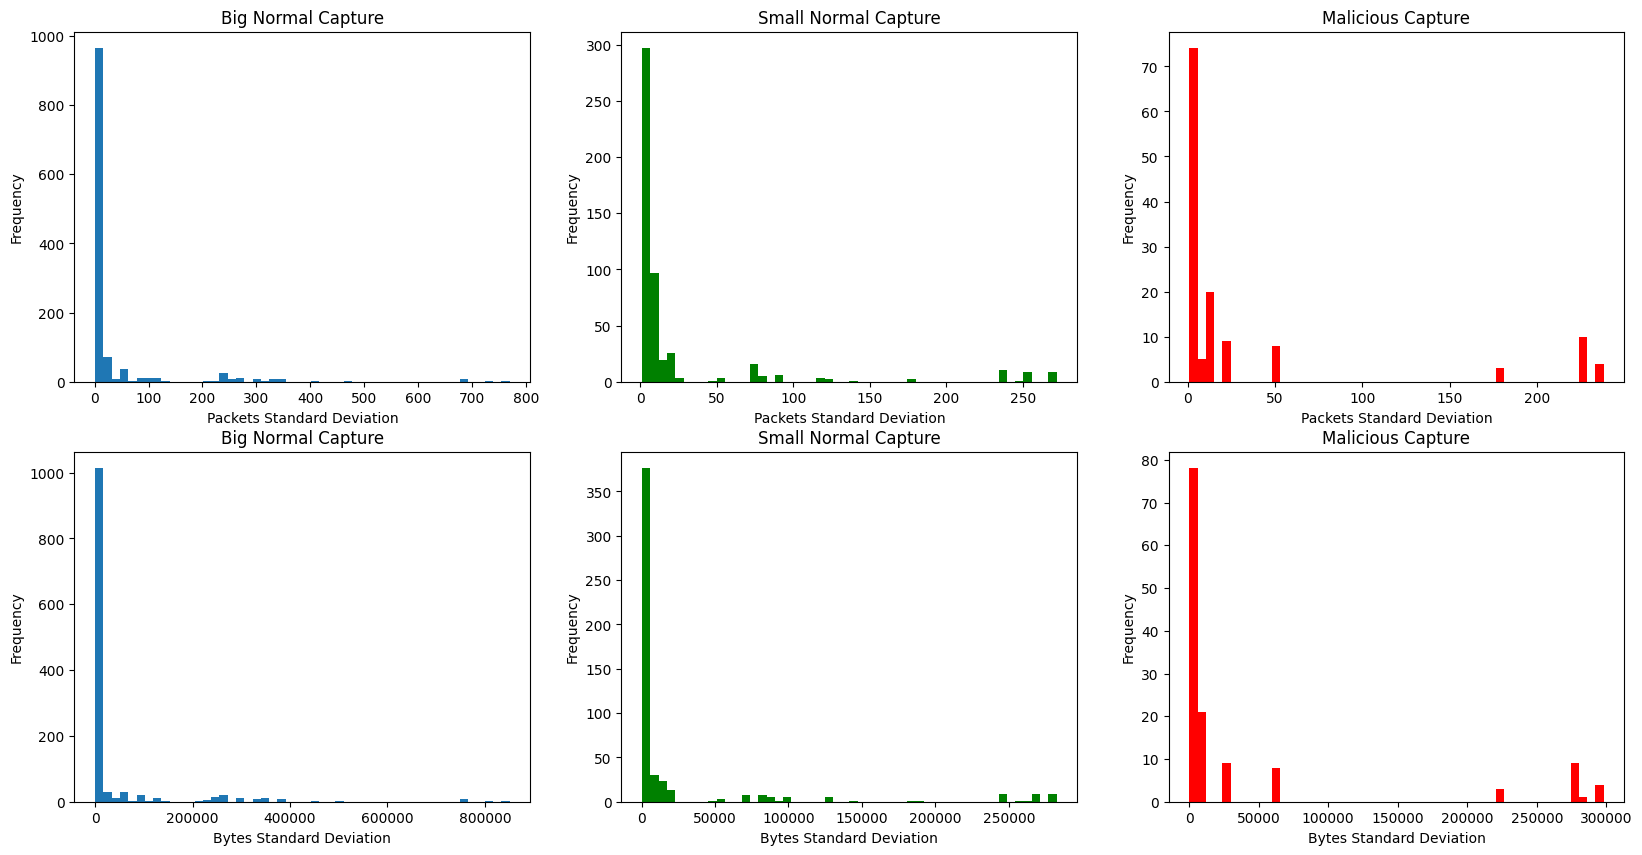

In [15]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(discord_normal_observation_dataset['packets_std_dev'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(discord_small_normal_observation_dataset['packets_std_dev'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(discord_malicious_observation_dataset['packets_std_dev'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Packets Standard Deviation')
plt.ylabel('Frequency')

# Make the same for bytes
plt.subplot(2, 3, 4)
plt.hist(discord_normal_observation_dataset['bytes_std_dev'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(discord_small_normal_observation_dataset['bytes_std_dev'], bins=50, color='green')
plt.title('Small Normal Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(discord_malicious_observation_dataset['bytes_std_dev'], bins=50, color='red')
plt.title('Malicious Capture')
plt.xlabel('Bytes Standard Deviation')
plt.ylabel('Frequency')

plt.show()

##### Boxplot of the Percentiles of Activity times

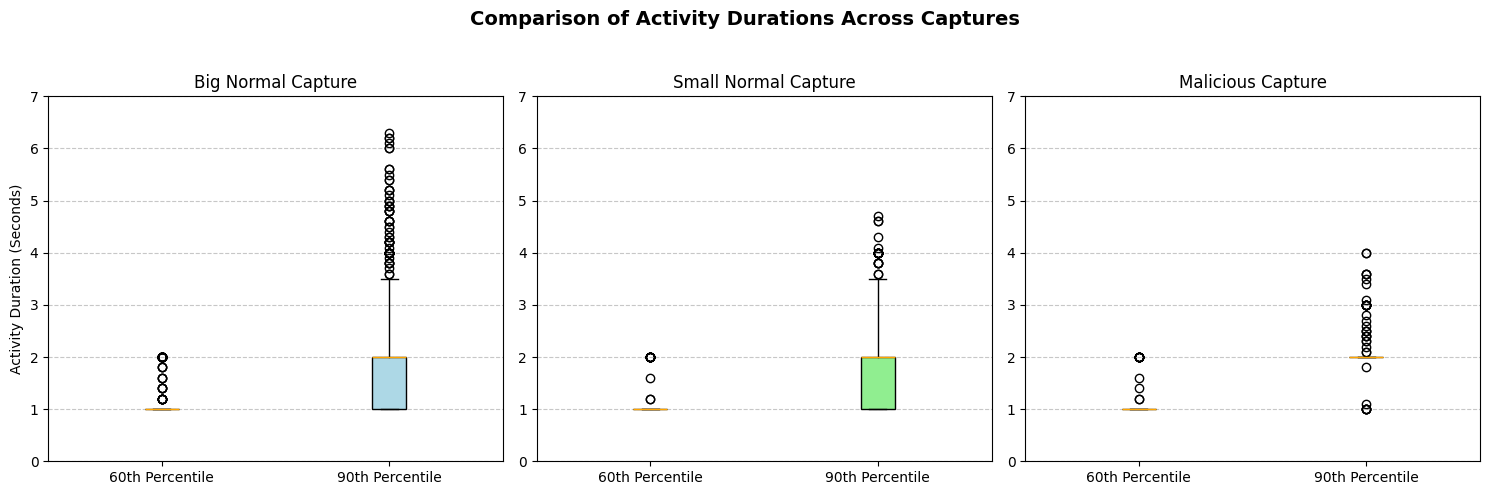

In [80]:
# Create a larger figure for better layout
plt.figure(figsize=(15, 5))

# Define consistent Y-axis range for all boxplots
y_range = [0, 7]  # Adjust this based on your data range

# Plot 1: Big Normal Capture
plt.subplot(1, 3, 1)
plt.boxplot([discord_normal_observation_dataset['60_percentile_activity_duration'],
             discord_normal_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Big Normal Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.ylabel('Activity Duration (Seconds)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Small Normal Capture
plt.subplot(1, 3, 2)
plt.boxplot([discord_small_normal_observation_dataset['60_percentile_activity_duration'],
             discord_small_normal_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightgreen"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Small Normal Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Malicious Capture
plt.subplot(1, 3, 3)
plt.boxplot([discord_malicious_observation_dataset['60_percentile_activity_duration'],
             discord_malicious_observation_dataset['90_percentile_activity_duration']],
            patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), 
            medianprops=dict(color="orange"),
            flierprops=dict(marker='o', color='red', markersize=6))
plt.title('Malicious Capture', fontsize=12)
plt.xticks([1, 2], ['60th Percentile', '90th Percentile'])
plt.ylim(y_range)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a main title
plt.suptitle('Comparison of Activity Durations Across Captures', fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the improved plot
plt.show()

#### Normalization and Split Process

In [36]:
# Perform normalization of the dataset (MinMaxScaler) - Use the training dataset to fit the scaler
scaler = MinMaxScaler()
scaler.fit(discord_normal_observation_dataset)

normalized_discord_normal_observation_dataset = scaler.transform(discord_normal_observation_dataset)
normalized_discord_normal_small_observation_dataset = scaler.transform(discord_small_normal_observation_dataset)
normalized_discord_malicious_observation_dataset = scaler.transform(discord_malicious_observation_dataset)

# Extract the features from the dataframe
train = normalized_discord_normal_observation_dataset
test = normalized_discord_malicious_observation_dataset
test_good = normalized_discord_normal_small_observation_dataset

#### Model Training

Models used:
1. Autoencoders
- Type: Neural Network-based
- Use Case: Anomaly detection
- How it works:
  - Train an autoencoder to reconstruct "normal" network traffic patterns from packet data.
  - During inference, unusual traffic (indicative of exfiltration) will have a higher reconstruction error.
- Why suitable: Autoencoders work well with unlabeled data and are ideal for detecting anomalies like data exfiltration.
1. Isolation Forest
- Type: Tree-based anomaly detection
- Use Case: Identify outlier network sessions
- How it works:
  - Isolation Forest isolates data points by randomly partitioning feature space.
  - Exfiltration traffic, which is rare or abnormal, is "isolated" faster.
- Why suitable: Works efficiently with high-dimensional data like packet captures.
1. One-Class SVM (Support Vector Machine)
- Type: Kernel-based anomaly detection
- Use Case: Classifies normal vs. anomalous behavior
- How it works:
  - Trains on normal packet behavior to create a decision boundary.
  - Exfiltration (anomalous data) lies outside the learned boundary.
- Why suitable: Handles packet-level feature extraction well and doesn't require labels.

##### One-Class SVM

In [45]:
# Initialize the OneClassSVM model (Unsupervised learning)
malicious_behavior_percentage = 0.0001
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=malicious_behavior_percentage)

# Train the model
ocsvm.fit(train)

# Test the model
predictions = ocsvm.predict(test)

good_predictions = ocsvm.predict(test_good)

##### Evaluation

In [ ]:
# Display the number of normal and malicious observations
print("FOR THE MALICIOUS OBSERVATIONS")
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(predictions[predictions == -1]) / len(predictions) * 100:.2f}%")

# Use Silhouette Score to evaluate the model

# Combine the normal and malicious observations
combined = np.concatenate((train, test))

# Predict the labels
labels = ocsvm.predict(combined)

# Calculate the silhouette score
silhouette = silhouette_score(combined, labels)
print(f"Silhouette Score: {silhouette:.2f}")

FOR THE MALICIOUS OBSERVATIONS
Normal observations:  99
Malicious observations:  34
Percentage of malicious observations: 25.56%
Silhouette Score: 0.96


In [34]:
print("\n\nFOR THE GOOD OBSERVATIONS")
print("Normal observations: ", len(good_predictions[good_predictions == 1]))
print("Malicious observations: ", len(good_predictions[good_predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(good_predictions[good_predictions == -1]) / len(good_predictions) * 100:.2f}%")



FOR THE GOOD OBSERVATIONS
Normal observations:  500
Malicious observations:  10
Percentage of malicious observations: 1.96%


##### Isolation Forest

In [75]:
# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
isolation_forest.fit(train)

# Predict anomalies
predictions = isolation_forest.predict(test_good)

##### Evaluation

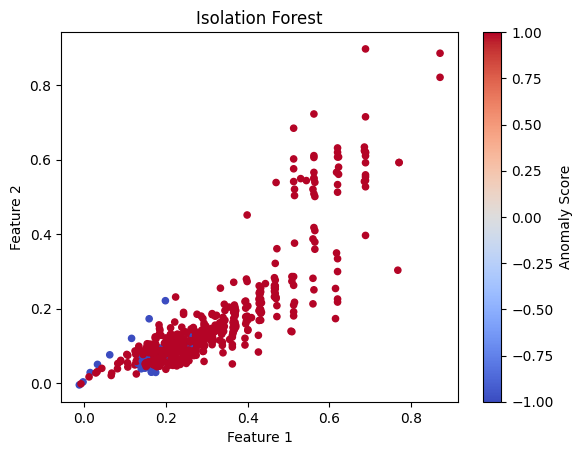

Normal observations:  470
Malicious observations:  40


In [74]:
# Visualize results
plt.scatter(test_good[:, 0], test_good[:, 1], c=predictions, cmap='coolwarm', s=20)
plt.title('Isolation Forest')
plt.colorbar(label='Anomaly Score')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check the percentage of malicious observations
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

##### Autoencoder

In [41]:
# Example for tabular data
input_dim = 22  # Number of features
encoding_dim = 5  # Latent space dimension

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Define the decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build the autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(train, train, epochs=100, batch_size=32, shuffle=True, validation_data=(test, test))

# Predict the anomalies
predictions = autoencoder.predict(test)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1884 - val_loss: 253.6660
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1736 - val_loss: 253.6833
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1577 - val_loss: 253.6965
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1354 - val_loss: 254.5448
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1080 - val_loss: 254.5538
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0851 - val_loss: 254.5328
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0670 - val_loss: 254.5208
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - val_loss: 254.5119
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0437 - val_loss: 254.5059
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - val_loss: 254.5018
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - val_loss: 254.4992
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

##### Evaluation

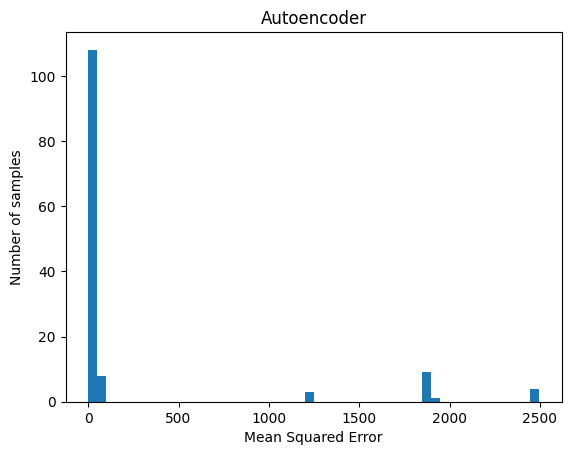

Number of anomalies:  34


In [44]:
# Calculate the mean squared error
mean_squared_error = np.mean(np.power(test - predictions, 2), axis=1)

# Visualize the results
plt.hist(mean_squared_error, bins=50)
plt.xlabel('Mean Squared Error')
plt.ylabel('Number of samples')
plt.title('Autoencoder')
plt.show()

# Check if there are any anomalies
threshold = 0.17
anomalies = mean_squared_error > threshold
print("Number of anomalies: ", len(mean_squared_error[anomalies]))